In [9]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

Clasificación = mapping de inputs a labels y optimizamos.

Metric learning = optimizamos cómo distribuir nuestras clases en el espacio. Las cosas que se parezcan juntas, las que no separadas.

In [10]:
mean, std = 0.1307, 0.3081

train_dataset = FashionMNIST('../data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [11]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [12]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [13]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        scores = F.log_softmax(self.fc1(output), dim=-1)
        return scores

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [14]:
def train_epoch(train_loader, model, loss_fn, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if target is not None:
            target = target.to(device)

        data = tuple(d.to(device) for d in data)

        optimizer.zero_grad()
        outputs = model(*data)
        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target
        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = outputs[0].max(1)[1]
        correct += pred.eq(target[0].view_as(pred)).sum().item()

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)


    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, loss_fn):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
            

        data = tuple(d.to(device) for d in data)

        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        loss_inputs = outputs
        if target is not None:
            target = (target.to(device),)
            loss_inputs += target

        pred = outputs[0].max(1)[1]
        correct += pred.eq(target[0].view_as(pred)).sum().item()

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        val_loss += loss.item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [15]:
embedding_net = EmbeddingNet().to(device)
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)
loss_fn = torch.nn.NLLLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [16]:
  for epoch in range(n_epochs):
       
        # Train stage
        train_loss, acc = train_epoch(train_loader, model, loss_fn, optimizer)
        scheduler.step()
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

        val_loss, acc = test_epoch(test_loader, model, loss_fn)
        val_loss /= len(test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss, acc)

        print(message)

Epoch: 1/10. Train set: Average loss: 1.3015 Accuracy: 52.24
Epoch: 1/10. Validation set: Average loss: 0.9082 Accuracy: 67.39
Epoch: 2/10. Train set: Average loss: 0.7769 Accuracy: 72.93
Epoch: 2/10. Validation set: Average loss: 0.7168 Accuracy: 78.71
Epoch: 3/10. Train set: Average loss: 0.6076 Accuracy: 82.24
Epoch: 3/10. Validation set: Average loss: 0.6116 Accuracy: 83.98
Epoch: 4/10. Train set: Average loss: 0.5270 Accuracy: 85.01
Epoch: 4/10. Validation set: Average loss: 0.5480 Accuracy: 84.58
Epoch: 5/10. Train set: Average loss: 0.4726 Accuracy: 86.28
Epoch: 5/10. Validation set: Average loss: 0.5975 Accuracy: 85.00
Epoch: 6/10. Train set: Average loss: 0.4234 Accuracy: 87.70
Epoch: 6/10. Validation set: Average loss: 0.5224 Accuracy: 85.92
Epoch: 7/10. Train set: Average loss: 0.3950 Accuracy: 88.38
Epoch: 7/10. Validation set: Average loss: 0.5382 Accuracy: 87.54
Epoch: 8/10. Train set: Average loss: 0.3619 Accuracy: 89.27
Epoch: 8/10. Validation set: Average loss: 0.5271 

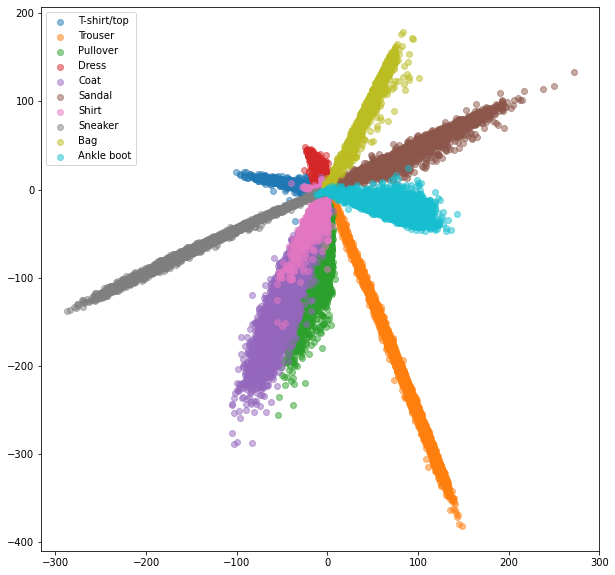

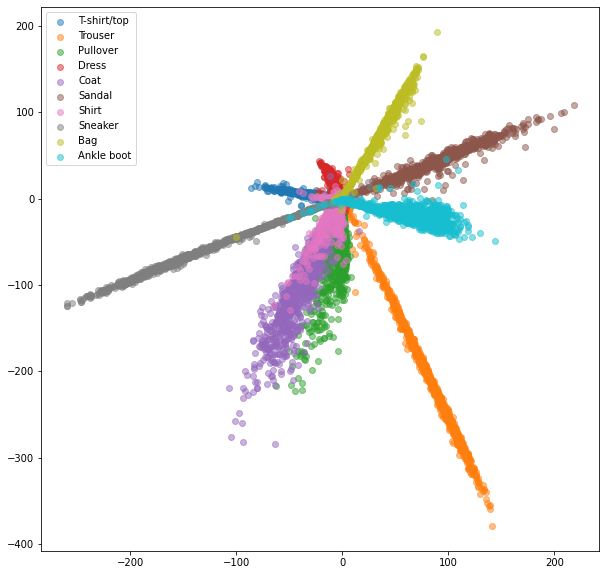

In [17]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

In [18]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.targets
            self.train_data = self.mnist_dataset.data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.targets
            self.test_data = self.mnist_dataset.data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), target

        
    def __len__(self):
        return len(self.mnist_dataset)

In [19]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # F.relu == max(0, self.margin - (distances + self.eps).sqrt())
        losses = 0.5 * (target.float() * distances +
                        (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

# Exercise 1

Complete the forward method for the siamese network. Remember it outputs 2 embeddings.

In [20]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)

        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

In [21]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

In [22]:
for epoch in range(n_epochs):

        # Train stage
        train_loss, acc = train_epoch(siamese_train_loader, model, loss_fn, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        val_loss, acc = test_epoch(siamese_test_loader, model, loss_fn)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)

        print(message)

Epoch: 1/10. Train set: Average loss: 0.0483
Epoch: 1/10. Validation set: Average loss: 0.0415
Epoch: 2/10. Train set: Average loss: 0.0367
Epoch: 2/10. Validation set: Average loss: 0.0406
Epoch: 3/10. Train set: Average loss: 0.0323
Epoch: 3/10. Validation set: Average loss: 0.0350
Epoch: 4/10. Train set: Average loss: 0.0289
Epoch: 4/10. Validation set: Average loss: 0.0320
Epoch: 5/10. Train set: Average loss: 0.0252
Epoch: 5/10. Validation set: Average loss: 0.0327
Epoch: 6/10. Train set: Average loss: 0.0248
Epoch: 6/10. Validation set: Average loss: 0.0301
Epoch: 7/10. Train set: Average loss: 0.0228
Epoch: 7/10. Validation set: Average loss: 0.0289
Epoch: 8/10. Train set: Average loss: 0.0209
Epoch: 8/10. Validation set: Average loss: 0.0278
Epoch: 9/10. Train set: Average loss: 0.0174
Epoch: 9/10. Validation set: Average loss: 0.0262
Epoch: 10/10. Train set: Average loss: 0.0162
Epoch: 10/10. Validation set: Average loss: 0.0263


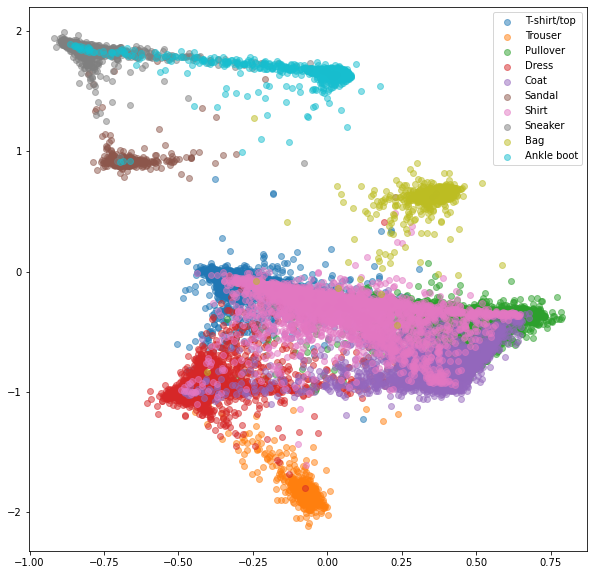

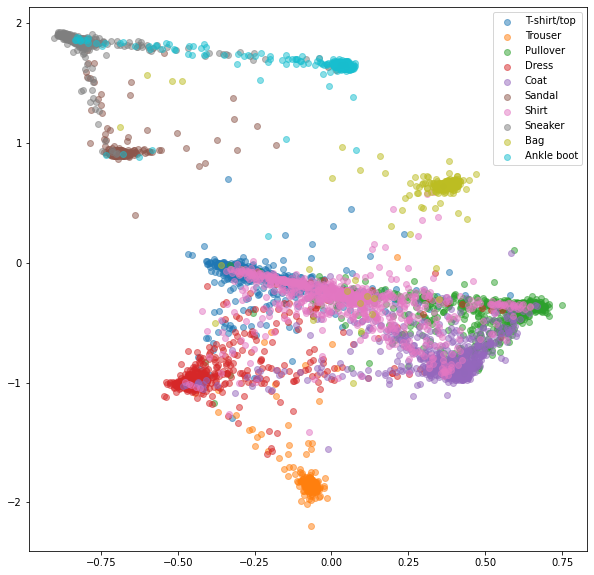

In [23]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Triplet Loss


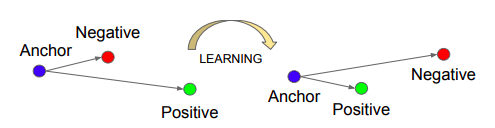

There are couple of problems with siamese and triplet networks.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

# Homework

A) Train FashionMNIST using a semi-hard Triplet Mining strategy, visualize the embeddings and comment what you observe. What are we trying to optimize? Does the criteria we are trying to optimize matches the results observed in the visualization?

Hints: You do not have to implement any Miner or Distance or anything of the sort. [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) implements everything we need.

Check the imports in the cell below for clues on what modules to use


Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it. The general template usage is something like this:


```
from pytorch_metric_learning import miners, losses
miner = miners.MultiSimilarityMiner()
loss_func = losses.TripletMarginLoss()

# your training loop
for i, (data, labels) in enumerate(dataloader):
	optimizer.zero_grad()
	embeddings = model(data)
	hard_pairs = miner(embeddings, labels)
	loss = loss_func(embeddings, labels, hard_pairs)
	loss.backward()
	optimizer.step()
```

In [24]:
!pip install pytorch-metric-learning faiss-gpu
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [25]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1): #(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        #output2 = self.embedding_net(x2)
        #output3 = self.embedding_net(x3)
        return output1#, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [26]:
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

In [27]:
from pytorch_metric_learning import reducers

miner = miners.TripletMarginMiner(margin = 0.2, distance = distances.CosineSimilarity(), type_of_triplets = "semihard")
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distances.CosineSimilarity()) # reducer = reducers.ThresholdReducer(low = 0)

#embedding_net = EmbeddingNet()
model = TripletNet(EmbeddingNet()).to(device)
#model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)

def train(train_loader, model, loss_func, mining_func, optimizer):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))



### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

for epoch in range(n_epochs):
        # Train stage
        train(train_loader, model, loss_func, miner, optimizer)
        #scheduler.step()
        #message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)
        #val_loss /= len(test_loader)
        #message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,val_loss)
        #print(message)

Epoch 0 Iteration 0: Loss = 0.12720122933387756, Number of mined triplets = 490609
Epoch 0 Iteration 20: Loss = 0.13943195343017578, Number of mined triplets = 254843
Epoch 0 Iteration 40: Loss = 0.14572477340698242, Number of mined triplets = 215355
Epoch 0 Iteration 60: Loss = 0.12329130619764328, Number of mined triplets = 202549
Epoch 0 Iteration 80: Loss = 0.11252376437187195, Number of mined triplets = 169300
Epoch 0 Iteration 100: Loss = 0.11027766019105911, Number of mined triplets = 150521
Epoch 0 Iteration 120: Loss = 0.13317975401878357, Number of mined triplets = 552370
Epoch 0 Iteration 140: Loss = 0.11642061173915863, Number of mined triplets = 199689
Epoch 0 Iteration 160: Loss = 0.11363746970891953, Number of mined triplets = 153280
Epoch 0 Iteration 180: Loss = 0.11068127304315567, Number of mined triplets = 154794
Epoch 0 Iteration 200: Loss = 0.110437773168087, Number of mined triplets = 144901
Epoch 0 Iteration 220: Loss = 0.11087757349014282, Number of mined triple

100%|██████████| 313/313 [00:01<00:00, 159.66it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.5995
Epoch 1 Iteration 0: Loss = 0.10521143674850464, Number of mined triplets = 158804
Epoch 1 Iteration 20: Loss = 0.11101014912128448, Number of mined triplets = 159721
Epoch 1 Iteration 40: Loss = 0.09927423298358917, Number of mined triplets = 143695
Epoch 1 Iteration 60: Loss = 0.09386460483074188, Number of mined triplets = 133632
Epoch 1 Iteration 80: Loss = 0.10450457781553268, Number of mined triplets = 151327
Epoch 1 Iteration 100: Loss = 0.09616822004318237, Number of mined triplets = 145485
Epoch 1 Iteration 120: Loss = 0.09139205515384674, Number of mined triplets = 175353
Epoch 1 Iteration 140: Loss = 0.0992305725812912, Number of mined triplets = 134507
Epoch 1 Iteration 160: Loss = 0.09019717574119568, Number of mined triplets = 133801
Epoch 1 Iteration 180: Loss = 0.09681769460439682, Number of mined triplets = 136482
Epoch 1 Iteration 200: Loss = 0.09459773451089859, Number of mined triplets = 165407
Epoch 1 Iter

100%|██████████| 313/313 [00:01<00:00, 160.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7102
Epoch 2 Iteration 0: Loss = 0.08784201741218567, Number of mined triplets = 160195
Epoch 2 Iteration 20: Loss = 0.10322032868862152, Number of mined triplets = 149015
Epoch 2 Iteration 40: Loss = 0.10212545841932297, Number of mined triplets = 174616
Epoch 2 Iteration 60: Loss = 0.0904352068901062, Number of mined triplets = 154661
Epoch 2 Iteration 80: Loss = 0.0931161418557167, Number of mined triplets = 126865
Epoch 2 Iteration 100: Loss = 0.08997629582881927, Number of mined triplets = 132443
Epoch 2 Iteration 120: Loss = 0.0873415544629097, Number of mined triplets = 154245
Epoch 2 Iteration 140: Loss = 0.09623111039400101, Number of mined triplets = 135108
Epoch 2 Iteration 160: Loss = 0.07815484702587128, Number of mined triplets = 122797
Epoch 2 Iteration 180: Loss = 0.08152666687965393, Number of mined triplets = 118359
Epoch 2 Iteration 200: Loss = 0.07414454221725464, Number of mined triplets = 110809
Epoch 2 Iterat

100%|██████████| 313/313 [00:01<00:00, 161.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.752
Epoch 3 Iteration 0: Loss = 0.09497183561325073, Number of mined triplets = 129762
Epoch 3 Iteration 20: Loss = 0.07568378746509552, Number of mined triplets = 131559
Epoch 3 Iteration 40: Loss = 0.09808247536420822, Number of mined triplets = 153784
Epoch 3 Iteration 60: Loss = 0.07094471901655197, Number of mined triplets = 146458
Epoch 3 Iteration 80: Loss = 0.08157814294099808, Number of mined triplets = 140661
Epoch 3 Iteration 100: Loss = 0.07464432716369629, Number of mined triplets = 128501
Epoch 3 Iteration 120: Loss = 0.08938347548246384, Number of mined triplets = 105108
Epoch 3 Iteration 140: Loss = 0.09526174515485764, Number of mined triplets = 108786
Epoch 3 Iteration 160: Loss = 0.06971149891614914, Number of mined triplets = 128097
Epoch 3 Iteration 180: Loss = 0.08075256645679474, Number of mined triplets = 114900
Epoch 3 Iteration 200: Loss = 0.09617350250482559, Number of mined triplets = 141049
Epoch 3 Iter

100%|██████████| 313/313 [00:01<00:00, 163.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7806000000000001
Epoch 4 Iteration 0: Loss = 0.0640997365117073, Number of mined triplets = 129620
Epoch 4 Iteration 20: Loss = 0.10321883112192154, Number of mined triplets = 162951
Epoch 4 Iteration 40: Loss = 0.09029519557952881, Number of mined triplets = 167180
Epoch 4 Iteration 60: Loss = 0.09048779308795929, Number of mined triplets = 147237
Epoch 4 Iteration 80: Loss = 0.07228899747133255, Number of mined triplets = 137118
Epoch 4 Iteration 100: Loss = 0.09440941363573074, Number of mined triplets = 109848
Epoch 4 Iteration 120: Loss = 0.07812812179327011, Number of mined triplets = 144824
Epoch 4 Iteration 140: Loss = 0.07278701663017273, Number of mined triplets = 119481
Epoch 4 Iteration 160: Loss = 0.09109436720609665, Number of mined triplets = 186233
Epoch 4 Iteration 180: Loss = 0.09032510966062546, Number of mined triplets = 116390
Epoch 4 Iteration 200: Loss = 0.07610969990491867, Number of mined triplets = 127630


100%|██████████| 313/313 [00:01<00:00, 165.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7852
Epoch 5 Iteration 0: Loss = 0.08502130210399628, Number of mined triplets = 139593
Epoch 5 Iteration 20: Loss = 0.08447094261646271, Number of mined triplets = 127326
Epoch 5 Iteration 40: Loss = 0.06443129479885101, Number of mined triplets = 109586
Epoch 5 Iteration 60: Loss = 0.08279033750295639, Number of mined triplets = 127921
Epoch 5 Iteration 80: Loss = 0.07612037658691406, Number of mined triplets = 129511
Epoch 5 Iteration 100: Loss = 0.08111727982759476, Number of mined triplets = 103621
Epoch 5 Iteration 120: Loss = 0.08300173282623291, Number of mined triplets = 111283
Epoch 5 Iteration 140: Loss = 0.10455034673213959, Number of mined triplets = 148436
Epoch 5 Iteration 160: Loss = 0.08258956670761108, Number of mined triplets = 155577
Epoch 5 Iteration 180: Loss = 0.08483872562646866, Number of mined triplets = 116478
Epoch 5 Iteration 200: Loss = 0.09008906781673431, Number of mined triplets = 116063
Epoch 5 Ite

100%|██████████| 313/313 [00:01<00:00, 161.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7696000000000001
Epoch 6 Iteration 0: Loss = 0.08386687189340591, Number of mined triplets = 125410
Epoch 6 Iteration 20: Loss = 0.09005626291036606, Number of mined triplets = 126235
Epoch 6 Iteration 40: Loss = 0.0942973867058754, Number of mined triplets = 109907
Epoch 6 Iteration 60: Loss = 0.07375450432300568, Number of mined triplets = 138925
Epoch 6 Iteration 80: Loss = 0.06624166667461395, Number of mined triplets = 128934
Epoch 6 Iteration 100: Loss = 0.08193129301071167, Number of mined triplets = 129395
Epoch 6 Iteration 120: Loss = 0.08936865627765656, Number of mined triplets = 126685
Epoch 6 Iteration 140: Loss = 0.10633089393377304, Number of mined triplets = 96634
Epoch 6 Iteration 160: Loss = 0.09644675254821777, Number of mined triplets = 134125
Epoch 6 Iteration 180: Loss = 0.08127792179584503, Number of mined triplets = 105315
Epoch 6 Iteration 200: Loss = 0.06974823772907257, Number of mined triplets = 107777
E

100%|██████████| 313/313 [00:01<00:00, 158.66it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7988000000000001
Epoch 7 Iteration 0: Loss = 0.08458811044692993, Number of mined triplets = 114410
Epoch 7 Iteration 20: Loss = 0.08680861443281174, Number of mined triplets = 101025
Epoch 7 Iteration 40: Loss = 0.0746694877743721, Number of mined triplets = 108648
Epoch 7 Iteration 60: Loss = 0.08096343278884888, Number of mined triplets = 142905
Epoch 7 Iteration 80: Loss = 0.09618746489286423, Number of mined triplets = 99139
Epoch 7 Iteration 100: Loss = 0.07072797417640686, Number of mined triplets = 112687
Epoch 7 Iteration 120: Loss = 0.07224643975496292, Number of mined triplets = 124145
Epoch 7 Iteration 140: Loss = 0.09689264744520187, Number of mined triplets = 103353
Epoch 7 Iteration 160: Loss = 0.08561531454324722, Number of mined triplets = 119653
Epoch 7 Iteration 180: Loss = 0.07445743680000305, Number of mined triplets = 128305
Epoch 7 Iteration 200: Loss = 0.07314176857471466, Number of mined triplets = 105050
E

100%|██████████| 313/313 [00:01<00:00, 163.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8098000000000001
Epoch 8 Iteration 0: Loss = 0.08092052489519119, Number of mined triplets = 97963
Epoch 8 Iteration 20: Loss = 0.0631527528166771, Number of mined triplets = 117651
Epoch 8 Iteration 40: Loss = 0.08302681893110275, Number of mined triplets = 87500
Epoch 8 Iteration 60: Loss = 0.08371306955814362, Number of mined triplets = 97990
Epoch 8 Iteration 80: Loss = 0.06372468173503876, Number of mined triplets = 127277
Epoch 8 Iteration 100: Loss = 0.06678899377584457, Number of mined triplets = 107853
Epoch 8 Iteration 120: Loss = 0.0706530213356018, Number of mined triplets = 99936
Epoch 8 Iteration 140: Loss = 0.06610085070133209, Number of mined triplets = 131097
Epoch 8 Iteration 160: Loss = 0.0872049480676651, Number of mined triplets = 106507
Epoch 8 Iteration 180: Loss = 0.052061714231967926, Number of mined triplets = 160706
Epoch 8 Iteration 200: Loss = 0.04989185556769371, Number of mined triplets = 161833
Epoch

100%|██████████| 313/313 [00:01<00:00, 162.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8183
Epoch 9 Iteration 0: Loss = 0.08245856314897537, Number of mined triplets = 108764
Epoch 9 Iteration 20: Loss = 0.0693342387676239, Number of mined triplets = 136558
Epoch 9 Iteration 40: Loss = 0.06974336504936218, Number of mined triplets = 119247
Epoch 9 Iteration 60: Loss = 0.05981433391571045, Number of mined triplets = 110409
Epoch 9 Iteration 80: Loss = 0.07807601243257523, Number of mined triplets = 91489
Epoch 9 Iteration 100: Loss = 0.08519294857978821, Number of mined triplets = 83804
Epoch 9 Iteration 120: Loss = 0.08256828784942627, Number of mined triplets = 114399
Epoch 9 Iteration 140: Loss = 0.07531429827213287, Number of mined triplets = 142470
Epoch 9 Iteration 160: Loss = 0.07942887395620346, Number of mined triplets = 99065
Epoch 9 Iteration 180: Loss = 0.083467498421669, Number of mined triplets = 96271
Epoch 9 Iteration 200: Loss = 0.07090378552675247, Number of mined triplets = 90929
Epoch 9 Iteration 2

100%|██████████| 313/313 [00:01<00:00, 156.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8168000000000001


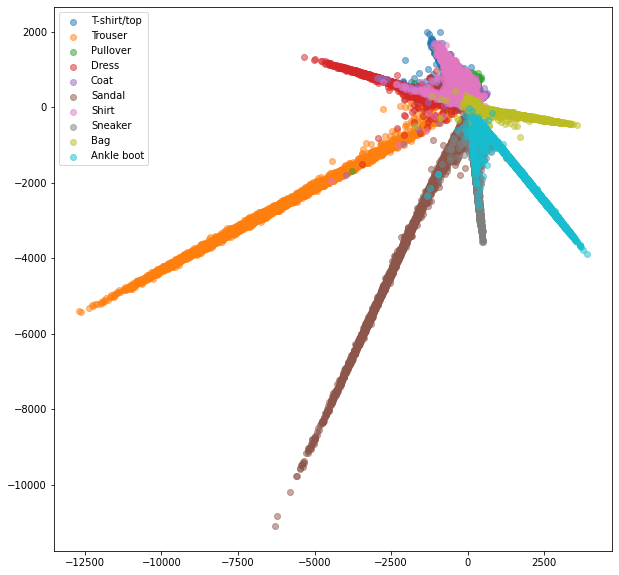

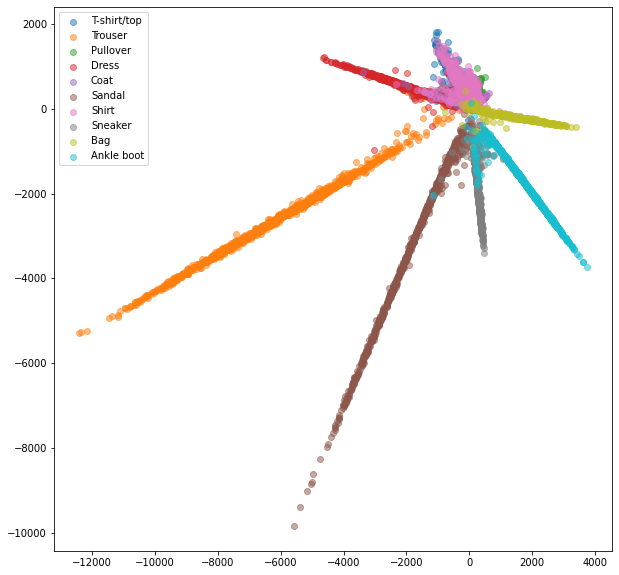

In [28]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

**Miner** = función que se encarga de dados los embeddings i las labels, seleccionar qué tripletas son hard, semi-hard o easy para calcular la loss.

Intentamos optimizar que el clasificador actue correctamente, es decir, que tengamos las diferentes prendas debidamente separadas. De este modo, vemos que generalmente nuestro modelo hace una buena faena.

Debemos destacar que las **camisas** (Shirt = color rosa) son las prendas que más le cuesta clasificar a nuestro modelo. El modelo confunde muchas de las camisas con **pullovers**, **camisetas** y **chaquetas**. Es lógico que a nuestro modelo le cueste diferenciar entre estas 4 prendas, ya que son prendas bastante parecidas.

B) Explain the difference between semi-hard, easy and hard triplets. Try training with all of the type of triplets mentioned above and comment on the effect they have on training, using loss curves and other evidence you find necessary.

**Semi-hard triplet** = tripleta en la cual el positive está más cerca del anchor que el negative.

**Hard triplet** = tripleta en la cual el negative está más cerca del anchor que el positive.

**Easy triplet** = tripleta que tiene una loss de 0.

In [29]:
def train(train_loader, model, loss_func, mining_func, optimizer):
    model.train()
    loss_1 = []
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))
            loss_1.append(loss.item())
    return loss_1
  
### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

**SEMI-HARD TRIPLET**

In [30]:
miner = miners.TripletMarginMiner(margin = 0.2, distance = distances.CosineSimilarity(), type_of_triplets = "semihard")
loss_semihard = []

for epoch in range(n_epochs):
        loss_sh = train(train_loader, model, loss_func, miner, optimizer)
        for i in loss_sh:
          loss_semihard.append(i)
        test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 0 Iteration 0: Loss = 0.0748666450381279, Number of mined triplets = 124233
Epoch 0 Iteration 20: Loss = 0.07653091847896576, Number of mined triplets = 128994
Epoch 0 Iteration 40: Loss = 0.07522381097078323, Number of mined triplets = 91475
Epoch 0 Iteration 60: Loss = 0.07704291492700577, Number of mined triplets = 83015
Epoch 0 Iteration 80: Loss = 0.08399634808301926, Number of mined triplets = 107969
Epoch 0 Iteration 100: Loss = 0.053063493221998215, Number of mined triplets = 147226
Epoch 0 Iteration 120: Loss = 0.09573373198509216, Number of mined triplets = 87813
Epoch 0 Iteration 140: Loss = 0.061242636293172836, Number of mined triplets = 97781
Epoch 0 Iteration 160: Loss = 0.07971268892288208, Number of mined triplets = 135867
Epoch 0 Iteration 180: Loss = 0.08642809838056564, Number of mined triplets = 103955
Epoch 0 Iteration 200: Loss = 0.05611026659607887, Number of mined triplets = 139506
Epoch 0 Iteration 220: Loss = 0.07810050994157791, Number of mined triplet

100%|██████████| 313/313 [00:01<00:00, 163.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8176
Epoch 1 Iteration 0: Loss = 0.07983946055173874, Number of mined triplets = 115421
Epoch 1 Iteration 20: Loss = 0.05933438614010811, Number of mined triplets = 142288
Epoch 1 Iteration 40: Loss = 0.08127181231975555, Number of mined triplets = 109759
Epoch 1 Iteration 60: Loss = 0.08031219989061356, Number of mined triplets = 101962
Epoch 1 Iteration 80: Loss = 0.07127410918474197, Number of mined triplets = 97481
Epoch 1 Iteration 100: Loss = 0.08817750215530396, Number of mined triplets = 95737
Epoch 1 Iteration 120: Loss = 0.09025626629590988, Number of mined triplets = 105181
Epoch 1 Iteration 140: Loss = 0.06774784624576569, Number of mined triplets = 94934
Epoch 1 Iteration 160: Loss = 0.08576466888189316, Number of mined triplets = 90169
Epoch 1 Iteration 180: Loss = 0.08142571151256561, Number of mined triplets = 78933
Epoch 1 Iteration 200: Loss = 0.06687591224908829, Number of mined triplets = 112815
Epoch 1 Iteratio

100%|██████████| 313/313 [00:01<00:00, 159.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8364
Epoch 2 Iteration 0: Loss = 0.08498357981443405, Number of mined triplets = 103869
Epoch 2 Iteration 20: Loss = 0.08308031409978867, Number of mined triplets = 130028
Epoch 2 Iteration 40: Loss = 0.0877910628914833, Number of mined triplets = 99926
Epoch 2 Iteration 60: Loss = 0.08578057587146759, Number of mined triplets = 105483
Epoch 2 Iteration 80: Loss = 0.07534793764352798, Number of mined triplets = 89099
Epoch 2 Iteration 100: Loss = 0.06830091029405594, Number of mined triplets = 100375
Epoch 2 Iteration 120: Loss = 0.06827002763748169, Number of mined triplets = 125492
Epoch 2 Iteration 140: Loss = 0.08122656494379044, Number of mined triplets = 116675
Epoch 2 Iteration 160: Loss = 0.09337802976369858, Number of mined triplets = 99170
Epoch 2 Iteration 180: Loss = 0.06764567643404007, Number of mined triplets = 100143
Epoch 2 Iteration 200: Loss = 0.06864435225725174, Number of mined triplets = 147471
Epoch 2 Iterati

100%|██████████| 313/313 [00:01<00:00, 159.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8289000000000001
Epoch 3 Iteration 0: Loss = 0.06666912883520126, Number of mined triplets = 122363
Epoch 3 Iteration 20: Loss = 0.049163807183504105, Number of mined triplets = 142243
Epoch 3 Iteration 40: Loss = 0.059267885982990265, Number of mined triplets = 111978
Epoch 3 Iteration 60: Loss = 0.05859442055225372, Number of mined triplets = 134679
Epoch 3 Iteration 80: Loss = 0.0708477571606636, Number of mined triplets = 97682
Epoch 3 Iteration 100: Loss = 0.07218319177627563, Number of mined triplets = 131370
Epoch 3 Iteration 120: Loss = 0.07589517533779144, Number of mined triplets = 120553
Epoch 3 Iteration 140: Loss = 0.06905873864889145, Number of mined triplets = 108848
Epoch 3 Iteration 160: Loss = 0.06933198869228363, Number of mined triplets = 116200
Epoch 3 Iteration 180: Loss = 0.06466027349233627, Number of mined triplets = 127577
Epoch 3 Iteration 200: Loss = 0.061791256070137024, Number of mined triplets = 11377

100%|██████████| 313/313 [00:01<00:00, 160.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8323
Epoch 4 Iteration 0: Loss = 0.09756644070148468, Number of mined triplets = 112863
Epoch 4 Iteration 20: Loss = 0.06803205609321594, Number of mined triplets = 120880
Epoch 4 Iteration 40: Loss = 0.0854780375957489, Number of mined triplets = 89442
Epoch 4 Iteration 60: Loss = 0.07143285870552063, Number of mined triplets = 128360
Epoch 4 Iteration 80: Loss = 0.06378226727247238, Number of mined triplets = 126050
Epoch 4 Iteration 100: Loss = 0.09115024656057358, Number of mined triplets = 88351
Epoch 4 Iteration 120: Loss = 0.06569377332925797, Number of mined triplets = 82590
Epoch 4 Iteration 140: Loss = 0.07693935930728912, Number of mined triplets = 106413
Epoch 4 Iteration 160: Loss = 0.06453629583120346, Number of mined triplets = 103153
Epoch 4 Iteration 180: Loss = 0.08410767465829849, Number of mined triplets = 97385
Epoch 4 Iteration 200: Loss = 0.07383393496274948, Number of mined triplets = 92458
Epoch 4 Iteration

100%|██████████| 313/313 [00:01<00:00, 160.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8436
Epoch 5 Iteration 0: Loss = 0.06568723171949387, Number of mined triplets = 85648
Epoch 5 Iteration 20: Loss = 0.10236703604459763, Number of mined triplets = 130788
Epoch 5 Iteration 40: Loss = 0.09196773171424866, Number of mined triplets = 115129
Epoch 5 Iteration 60: Loss = 0.07785572856664658, Number of mined triplets = 98747
Epoch 5 Iteration 80: Loss = 0.08368371427059174, Number of mined triplets = 95220
Epoch 5 Iteration 100: Loss = 0.0787438452243805, Number of mined triplets = 110730
Epoch 5 Iteration 120: Loss = 0.06603877991437912, Number of mined triplets = 89019
Epoch 5 Iteration 140: Loss = 0.057357702404260635, Number of mined triplets = 136987
Epoch 5 Iteration 160: Loss = 0.0543520413339138, Number of mined triplets = 115221
Epoch 5 Iteration 180: Loss = 0.062271200120449066, Number of mined triplets = 119346
Epoch 5 Iteration 200: Loss = 0.06509220600128174, Number of mined triplets = 112070
Epoch 5 Iterati

100%|██████████| 313/313 [00:01<00:00, 161.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8425
Epoch 6 Iteration 0: Loss = 0.06760220229625702, Number of mined triplets = 110740
Epoch 6 Iteration 20: Loss = 0.07492570579051971, Number of mined triplets = 83728
Epoch 6 Iteration 40: Loss = 0.07840780168771744, Number of mined triplets = 112601
Epoch 6 Iteration 60: Loss = 0.060361381620168686, Number of mined triplets = 121531
Epoch 6 Iteration 80: Loss = 0.05432505160570145, Number of mined triplets = 100912
Epoch 6 Iteration 100: Loss = 0.09028555452823639, Number of mined triplets = 150435
Epoch 6 Iteration 120: Loss = 0.06485100090503693, Number of mined triplets = 155617
Epoch 6 Iteration 140: Loss = 0.08367687463760376, Number of mined triplets = 141755
Epoch 6 Iteration 160: Loss = 0.08848928660154343, Number of mined triplets = 93207
Epoch 6 Iteration 180: Loss = 0.07022003829479218, Number of mined triplets = 116672
Epoch 6 Iteration 200: Loss = 0.05356273800134659, Number of mined triplets = 107504
Epoch 6 Iter

100%|██████████| 313/313 [00:01<00:00, 158.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8462000000000001
Epoch 7 Iteration 0: Loss = 0.054745860397815704, Number of mined triplets = 102329
Epoch 7 Iteration 20: Loss = 0.06340061873197556, Number of mined triplets = 103618
Epoch 7 Iteration 40: Loss = 0.09647510200738907, Number of mined triplets = 123174
Epoch 7 Iteration 60: Loss = 0.08692056685686111, Number of mined triplets = 74769
Epoch 7 Iteration 80: Loss = 0.08255030959844589, Number of mined triplets = 98553
Epoch 7 Iteration 100: Loss = 0.07012736052274704, Number of mined triplets = 85916
Epoch 7 Iteration 120: Loss = 0.07249466329813004, Number of mined triplets = 129300
Epoch 7 Iteration 140: Loss = 0.07125233858823776, Number of mined triplets = 136397
Epoch 7 Iteration 160: Loss = 0.06512206792831421, Number of mined triplets = 153281
Epoch 7 Iteration 180: Loss = 0.07419893890619278, Number of mined triplets = 114375
Epoch 7 Iteration 200: Loss = 0.05823083594441414, Number of mined triplets = 118079
E

100%|██████████| 313/313 [00:01<00:00, 160.75it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8365
Epoch 8 Iteration 0: Loss = 0.08512779325246811, Number of mined triplets = 91365
Epoch 8 Iteration 20: Loss = 0.05219785124063492, Number of mined triplets = 121796
Epoch 8 Iteration 40: Loss = 0.07255489379167557, Number of mined triplets = 123420
Epoch 8 Iteration 60: Loss = 0.05579335242509842, Number of mined triplets = 138267
Epoch 8 Iteration 80: Loss = 0.06246315315365791, Number of mined triplets = 109060
Epoch 8 Iteration 100: Loss = 0.06911613792181015, Number of mined triplets = 113085
Epoch 8 Iteration 120: Loss = 0.07476520538330078, Number of mined triplets = 120157
Epoch 8 Iteration 140: Loss = 0.059580106288194656, Number of mined triplets = 119570
Epoch 8 Iteration 160: Loss = 0.08714234083890915, Number of mined triplets = 110646
Epoch 8 Iteration 180: Loss = 0.06350664794445038, Number of mined triplets = 127349
Epoch 8 Iteration 200: Loss = 0.07310861349105835, Number of mined triplets = 81861
Epoch 8 Iter

100%|██████████| 313/313 [00:01<00:00, 158.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8543000000000001
Epoch 9 Iteration 0: Loss = 0.059690382331609726, Number of mined triplets = 91891
Epoch 9 Iteration 20: Loss = 0.06930259615182877, Number of mined triplets = 137157
Epoch 9 Iteration 40: Loss = 0.07429219782352448, Number of mined triplets = 94095
Epoch 9 Iteration 60: Loss = 0.07972192019224167, Number of mined triplets = 89537
Epoch 9 Iteration 80: Loss = 0.05238404497504234, Number of mined triplets = 160055
Epoch 9 Iteration 100: Loss = 0.06544903665781021, Number of mined triplets = 109012
Epoch 9 Iteration 120: Loss = 0.07396095991134644, Number of mined triplets = 137815
Epoch 9 Iteration 140: Loss = 0.08286584168672562, Number of mined triplets = 76168
Epoch 9 Iteration 160: Loss = 0.07928111404180527, Number of mined triplets = 102392
Epoch 9 Iteration 180: Loss = 0.06914234161376953, Number of mined triplets = 92763
Epoch 9 Iteration 200: Loss = 0.047701962292194366, Number of mined triplets = 145087
Ep

100%|██████████| 313/313 [00:01<00:00, 159.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8538


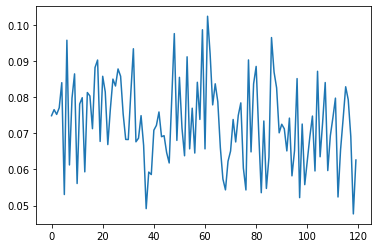

In [31]:
plt.plot(loss_semihard, label="training loss")

**HARD TRIPLET**

In [32]:
miner = miners.TripletMarginMiner(margin = 0.2, distance = distances.CosineSimilarity(), type_of_triplets = "hard")
loss_hard = []

for epoch in range(n_epochs):
        loss_h = train(train_loader, model, loss_func, miner, optimizer)
        for i in loss_h:
          loss_hard.append(i)
        test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 0 Iteration 0: Loss = 0.5071015357971191, Number of mined triplets = 35085
Epoch 0 Iteration 20: Loss = 0.3100750744342804, Number of mined triplets = 67530
Epoch 0 Iteration 40: Loss = 0.22338104248046875, Number of mined triplets = 100270
Epoch 0 Iteration 60: Loss = 0.20204512774944305, Number of mined triplets = 111927
Epoch 0 Iteration 80: Loss = 0.20156140625476837, Number of mined triplets = 141725
Epoch 0 Iteration 100: Loss = 0.2015880048274994, Number of mined triplets = 191440
Epoch 0 Iteration 120: Loss = 0.2007303386926651, Number of mined triplets = 109131
Epoch 0 Iteration 140: Loss = 0.24393460154533386, Number of mined triplets = 107355
Epoch 0 Iteration 160: Loss = 0.21293462812900543, Number of mined triplets = 85001
Epoch 0 Iteration 180: Loss = 0.21942470967769623, Number of mined triplets = 97987
Epoch 0 Iteration 200: Loss = 0.2012900412082672, Number of mined triplets = 84518
Epoch 0 Iteration 220: Loss = 0.2070161998271942, Number of mined triplets = 1036

100%|██████████| 313/313 [00:01<00:00, 158.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6499
Epoch 1 Iteration 0: Loss = 0.20135997235774994, Number of mined triplets = 131886
Epoch 1 Iteration 20: Loss = 0.20386546850204468, Number of mined triplets = 110326
Epoch 1 Iteration 40: Loss = 0.20112919807434082, Number of mined triplets = 129181
Epoch 1 Iteration 60: Loss = 0.20277619361877441, Number of mined triplets = 108415
Epoch 1 Iteration 80: Loss = 0.20228122174739838, Number of mined triplets = 140523
Epoch 1 Iteration 100: Loss = 0.20161432027816772, Number of mined triplets = 125232
Epoch 1 Iteration 120: Loss = 0.2742011249065399, Number of mined triplets = 153750
Epoch 1 Iteration 140: Loss = 0.201833575963974, Number of mined triplets = 107540
Epoch 1 Iteration 160: Loss = 0.20116481184959412, Number of mined triplets = 143679
Epoch 1 Iteration 180: Loss = 0.20162346959114075, Number of mined triplets = 144167
Epoch 1 Iteration 200: Loss = 0.20060010254383087, Number of mined triplets = 155075
Epoch 1 Iterat

100%|██████████| 313/313 [00:01<00:00, 161.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6158
Epoch 2 Iteration 0: Loss = 0.2014511078596115, Number of mined triplets = 122490
Epoch 2 Iteration 20: Loss = 0.2006986439228058, Number of mined triplets = 129142
Epoch 2 Iteration 40: Loss = 0.20156244933605194, Number of mined triplets = 121142
Epoch 2 Iteration 60: Loss = 0.2008928507566452, Number of mined triplets = 97888
Epoch 2 Iteration 80: Loss = 0.20069526135921478, Number of mined triplets = 167486
Epoch 2 Iteration 100: Loss = 0.20026090741157532, Number of mined triplets = 136943
Epoch 2 Iteration 120: Loss = 0.20173969864845276, Number of mined triplets = 65369
Epoch 2 Iteration 140: Loss = 0.20071488618850708, Number of mined triplets = 109092
Epoch 2 Iteration 160: Loss = 0.20026622712612152, Number of mined triplets = 135875
Epoch 2 Iteration 180: Loss = 0.20227035880088806, Number of mined triplets = 108649
Epoch 2 Iteration 200: Loss = 0.20124739408493042, Number of mined triplets = 112446
Epoch 2 Iteratio

100%|██████████| 313/313 [00:01<00:00, 160.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6592
Epoch 3 Iteration 0: Loss = 0.20075440406799316, Number of mined triplets = 106777
Epoch 3 Iteration 20: Loss = 0.2008184790611267, Number of mined triplets = 105067
Epoch 3 Iteration 40: Loss = 0.20026446878910065, Number of mined triplets = 188395
Epoch 3 Iteration 60: Loss = 0.20032666623592377, Number of mined triplets = 124280
Epoch 3 Iteration 80: Loss = 0.2002481073141098, Number of mined triplets = 166048
Epoch 3 Iteration 100: Loss = 0.20137068629264832, Number of mined triplets = 89926
Epoch 3 Iteration 120: Loss = 0.2164067178964615, Number of mined triplets = 105648
Epoch 3 Iteration 140: Loss = 0.20019279420375824, Number of mined triplets = 113301
Epoch 3 Iteration 160: Loss = 0.20015619695186615, Number of mined triplets = 135645
Epoch 3 Iteration 180: Loss = 0.20099765062332153, Number of mined triplets = 140461
Epoch 3 Iteration 200: Loss = 0.20122098922729492, Number of mined triplets = 141919
Epoch 3 Iterati

100%|██████████| 313/313 [00:01<00:00, 160.89it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6395000000000001
Epoch 4 Iteration 0: Loss = 0.20061850547790527, Number of mined triplets = 116111
Epoch 4 Iteration 20: Loss = 0.2002047747373581, Number of mined triplets = 100629
Epoch 4 Iteration 40: Loss = 0.20020854473114014, Number of mined triplets = 115145
Epoch 4 Iteration 60: Loss = 0.20017369091510773, Number of mined triplets = 87207
Epoch 4 Iteration 80: Loss = 0.20023368299007416, Number of mined triplets = 152654
Epoch 4 Iteration 100: Loss = 0.20013414323329926, Number of mined triplets = 99561
Epoch 4 Iteration 120: Loss = 0.20037394762039185, Number of mined triplets = 104950
Epoch 4 Iteration 140: Loss = 0.20013751089572906, Number of mined triplets = 128438
Epoch 4 Iteration 160: Loss = 0.20013898611068726, Number of mined triplets = 159801
Epoch 4 Iteration 180: Loss = 0.20036859810352325, Number of mined triplets = 104506
Epoch 4 Iteration 200: Loss = 0.20011115074157715, Number of mined triplets = 103032
Ep

100%|██████████| 313/313 [00:01<00:00, 159.47it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6167
Epoch 5 Iteration 0: Loss = 0.20010292530059814, Number of mined triplets = 121984
Epoch 5 Iteration 20: Loss = 0.20023715496063232, Number of mined triplets = 120386
Epoch 5 Iteration 40: Loss = 0.20021577179431915, Number of mined triplets = 132502
Epoch 5 Iteration 60: Loss = 0.20008313655853271, Number of mined triplets = 148781
Epoch 5 Iteration 80: Loss = 0.2000734806060791, Number of mined triplets = 156652
Epoch 5 Iteration 100: Loss = 0.20010210573673248, Number of mined triplets = 107338
Epoch 5 Iteration 120: Loss = 0.20007391273975372, Number of mined triplets = 150315
Epoch 5 Iteration 140: Loss = 0.20005843043327332, Number of mined triplets = 136287
Epoch 5 Iteration 160: Loss = 0.200151726603508, Number of mined triplets = 107520
Epoch 5 Iteration 180: Loss = 0.20011916756629944, Number of mined triplets = 144465
Epoch 5 Iteration 200: Loss = 0.20011350512504578, Number of mined triplets = 141645
Epoch 5 Iterat

100%|██████████| 313/313 [00:01<00:00, 158.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6109
Epoch 6 Iteration 0: Loss = 0.20004993677139282, Number of mined triplets = 199307
Epoch 6 Iteration 20: Loss = 0.20011480152606964, Number of mined triplets = 129403
Epoch 6 Iteration 40: Loss = 0.20022664964199066, Number of mined triplets = 115987
Epoch 6 Iteration 60: Loss = 0.20004048943519592, Number of mined triplets = 151469
Epoch 6 Iteration 80: Loss = 0.20005527138710022, Number of mined triplets = 154023
Epoch 6 Iteration 100: Loss = 0.20005324482917786, Number of mined triplets = 141170
Epoch 6 Iteration 120: Loss = 0.2000749260187149, Number of mined triplets = 111305
Epoch 6 Iteration 140: Loss = 0.20016857981681824, Number of mined triplets = 129164
Epoch 6 Iteration 160: Loss = 0.2000623494386673, Number of mined triplets = 117504
Epoch 6 Iteration 180: Loss = 0.20006820559501648, Number of mined triplets = 146456
Epoch 6 Iteration 200: Loss = 0.20004938542842865, Number of mined triplets = 112451
Epoch 6 Itera

100%|██████████| 313/313 [00:01<00:00, 157.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.631
Epoch 7 Iteration 0: Loss = 0.20006027817726135, Number of mined triplets = 110063
Epoch 7 Iteration 20: Loss = 0.20003049075603485, Number of mined triplets = 169225
Epoch 7 Iteration 40: Loss = 0.20004568994045258, Number of mined triplets = 138795
Epoch 7 Iteration 60: Loss = 0.20005786418914795, Number of mined triplets = 146958
Epoch 7 Iteration 80: Loss = 0.20015962421894073, Number of mined triplets = 109614
Epoch 7 Iteration 100: Loss = 0.20005370676517487, Number of mined triplets = 166662
Epoch 7 Iteration 120: Loss = 0.20015354454517365, Number of mined triplets = 114718
Epoch 7 Iteration 140: Loss = 0.20002707839012146, Number of mined triplets = 122779
Epoch 7 Iteration 160: Loss = 0.2000322788953781, Number of mined triplets = 152015
Epoch 7 Iteration 180: Loss = 0.20002545416355133, Number of mined triplets = 141152
Epoch 7 Iteration 200: Loss = 0.20003198087215424, Number of mined triplets = 140972
Epoch 7 Itera

100%|██████████| 313/313 [00:01<00:00, 158.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6191
Epoch 8 Iteration 0: Loss = 0.20002734661102295, Number of mined triplets = 162148
Epoch 8 Iteration 20: Loss = 0.20008516311645508, Number of mined triplets = 164813
Epoch 8 Iteration 40: Loss = 0.2000449001789093, Number of mined triplets = 166931
Epoch 8 Iteration 60: Loss = 0.20004902780056, Number of mined triplets = 110274
Epoch 8 Iteration 80: Loss = 0.20007511973381042, Number of mined triplets = 175794
Epoch 8 Iteration 100: Loss = 0.20006439089775085, Number of mined triplets = 124370
Epoch 8 Iteration 120: Loss = 0.200044646859169, Number of mined triplets = 161208
Epoch 8 Iteration 140: Loss = 0.20002447068691254, Number of mined triplets = 125472
Epoch 8 Iteration 160: Loss = 0.20005108416080475, Number of mined triplets = 113250
Epoch 8 Iteration 180: Loss = 0.20002996921539307, Number of mined triplets = 156373
Epoch 8 Iteration 200: Loss = 0.20004335045814514, Number of mined triplets = 136586
Epoch 8 Iteration

100%|██████████| 313/313 [00:01<00:00, 158.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6149
Epoch 9 Iteration 0: Loss = 0.20003090798854828, Number of mined triplets = 119021
Epoch 9 Iteration 20: Loss = 0.20008444786071777, Number of mined triplets = 105893
Epoch 9 Iteration 40: Loss = 0.20003049075603485, Number of mined triplets = 87596
Epoch 9 Iteration 60: Loss = 0.2000388205051422, Number of mined triplets = 144006
Epoch 9 Iteration 80: Loss = 0.20002838969230652, Number of mined triplets = 129832
Epoch 9 Iteration 100: Loss = 0.20004962384700775, Number of mined triplets = 112039
Epoch 9 Iteration 120: Loss = 0.20002469420433044, Number of mined triplets = 157734
Epoch 9 Iteration 140: Loss = 0.20006251335144043, Number of mined triplets = 113538
Epoch 9 Iteration 160: Loss = 0.2000216692686081, Number of mined triplets = 145691
Epoch 9 Iteration 180: Loss = 0.2000397890806198, Number of mined triplets = 115849
Epoch 9 Iteration 200: Loss = 0.20002290606498718, Number of mined triplets = 142321
Epoch 9 Iterati

100%|██████████| 313/313 [00:01<00:00, 160.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6269


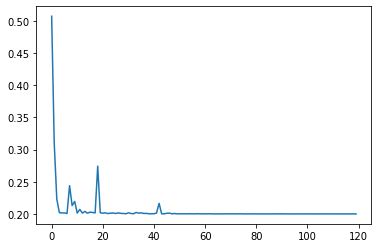

In [33]:
plt.plot(loss_hard, label="training loss")

**EASY TRIPLET**

In [34]:
miner = miners.TripletMarginMiner(margin = 0.2, distance = distances.CosineSimilarity(), type_of_triplets = "easy")
loss_easy = []

for epoch in range(n_epochs):
        loss_e = train(train_loader, model, loss_func, miner, optimizer)
        for i in loss_e:
          loss_easy.append(i)
        test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 0 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 0 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 161.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 1 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 1 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 159.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 2 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 2 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 157.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 3 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 3 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 162.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 4 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 4 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 156.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 5 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 5 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 161.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 6 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 6 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 159.55it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 7 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 7 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 160.92it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 8 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 8 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 159.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001
Epoch 9 Iteration 0: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 20: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 40: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 60: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 80: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 100: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 120: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 140: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 160: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 180: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 200: Loss = 0.0, Number of mined triplets = 0
Epoch 9 Iteration 220: Loss = 0.0, Number of mined triplets = 0


100%|██████████| 313/313 [00:01<00:00, 161.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6224000000000001


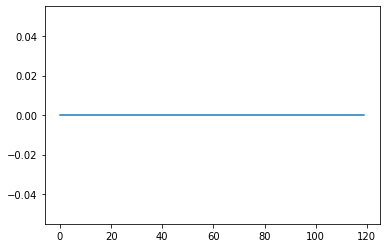

In [35]:
plt.plot(loss_easy, label="training loss")

Text(0.5, 0.98, 'Losses')

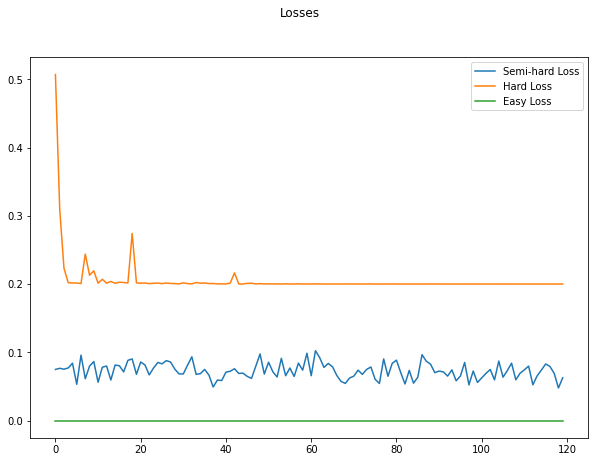

In [36]:
fig, axs = plt.subplots(1, figsize=(10, 7))

axs.plot(loss_semihard, label='Semi-hard Loss')
axs.plot(loss_hard, label='Hard Loss')
axs.plot(loss_easy, label='Easy Loss')
axs.legend()

plt.suptitle("Losses")

C) Find a way to quantitatively measure how good the embeddings are.

Cuando he resuelto el ejercicio A, ya he implementado una mesura cuantitativa donde se puede ver la Accuracy de los diferentes embeddings en cada una de las epochs. Esto lo hacemos a través de *accuracy_calculator.get_accuracy*.

D) Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE. The T-SNE library is installed in the cell below check the [github repo](https://github.com/DmitryUlyanov/Multicore-TSNE) for info on how to use it. 



Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so don't visualize the embeddings for every sample. Randomly select a few**

In [37]:
!pip install pytorch-metric-learning faiss-gpu
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


# THIS FUNCTION MIGHT BE USEFUL FOR C
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

In [38]:
!pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_components=2, verbose=1, n_jobs=2)

In [39]:
class EmbeddingNet2(nn.Module):
    def __init__(self):
        super(EmbeddingNet2, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 128),
                                nn.PReLU(),
                                nn.Linear(128, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


miner = miners.TripletMarginMiner(margin = 0.2, distance = distances.CosineSimilarity(), type_of_triplets = "semihard")
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distances.CosineSimilarity()) # reducer = reducers.ThresholdReducer(low = 0)

#embedding_net = EmbeddingNet()
model = TripletNet(EmbeddingNet2()).to(device)
#model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10

accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)

def train(train_loader, model, loss_func, mining_func, optimizer):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))



### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return test_embeddings, test_labels

for epoch in range(10):
        # Train stage
        train(train_loader, model, loss_func, miner, optimizer)
        #scheduler.step()
        #message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        test(train_dataset, test_dataset, model, accuracy_calculator)
        #val_loss /= len(test_loader)
        #message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,val_loss)
        #print(message)

Epoch 0 Iteration 0: Loss = 0.17208725214004517, Number of mined triplets = 811453
Epoch 0 Iteration 20: Loss = 0.13324028253555298, Number of mined triplets = 198857
Epoch 0 Iteration 40: Loss = 0.11792916059494019, Number of mined triplets = 163647
Epoch 0 Iteration 60: Loss = 0.11779589205980301, Number of mined triplets = 125927
Epoch 0 Iteration 80: Loss = 0.10378103703260422, Number of mined triplets = 147416
Epoch 0 Iteration 100: Loss = 0.11588602513074875, Number of mined triplets = 138246
Epoch 0 Iteration 120: Loss = 0.1004875898361206, Number of mined triplets = 159121
Epoch 0 Iteration 140: Loss = 0.10561513900756836, Number of mined triplets = 163320
Epoch 0 Iteration 160: Loss = 0.09781354665756226, Number of mined triplets = 162677
Epoch 0 Iteration 180: Loss = 0.09572296589612961, Number of mined triplets = 146352
Epoch 0 Iteration 200: Loss = 0.09406107664108276, Number of mined triplets = 142995
Epoch 0 Iteration 220: Loss = 0.09641490131616592, Number of mined tripl

100%|██████████| 313/313 [00:01<00:00, 159.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7015
Epoch 1 Iteration 0: Loss = 0.09362393617630005, Number of mined triplets = 144659
Epoch 1 Iteration 20: Loss = 0.09555640071630478, Number of mined triplets = 121389
Epoch 1 Iteration 40: Loss = 0.09657479077577591, Number of mined triplets = 150816
Epoch 1 Iteration 60: Loss = 0.0962202325463295, Number of mined triplets = 127121
Epoch 1 Iteration 80: Loss = 0.09210892021656036, Number of mined triplets = 137071
Epoch 1 Iteration 100: Loss = 0.07862033694982529, Number of mined triplets = 134044
Epoch 1 Iteration 120: Loss = 0.07546704262495041, Number of mined triplets = 157649
Epoch 1 Iteration 140: Loss = 0.08125166594982147, Number of mined triplets = 131783
Epoch 1 Iteration 160: Loss = 0.08716386556625366, Number of mined triplets = 135872
Epoch 1 Iteration 180: Loss = 0.065770722925663, Number of mined triplets = 163768
Epoch 1 Iteration 200: Loss = 0.08697566390037537, Number of mined triplets = 139887
Epoch 1 Iterat

100%|██████████| 313/313 [00:01<00:00, 160.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7571
Epoch 2 Iteration 0: Loss = 0.08281116187572479, Number of mined triplets = 106883
Epoch 2 Iteration 20: Loss = 0.0795396938920021, Number of mined triplets = 115491
Epoch 2 Iteration 40: Loss = 0.08423364162445068, Number of mined triplets = 131467
Epoch 2 Iteration 60: Loss = 0.08349710702896118, Number of mined triplets = 143137
Epoch 2 Iteration 80: Loss = 0.08600685745477676, Number of mined triplets = 122860
Epoch 2 Iteration 100: Loss = 0.0882127657532692, Number of mined triplets = 105197
Epoch 2 Iteration 120: Loss = 0.07996999472379684, Number of mined triplets = 115658
Epoch 2 Iteration 140: Loss = 0.08202656358480453, Number of mined triplets = 139444
Epoch 2 Iteration 160: Loss = 0.09613506495952606, Number of mined triplets = 118382
Epoch 2 Iteration 180: Loss = 0.08734709024429321, Number of mined triplets = 141192
Epoch 2 Iteration 200: Loss = 0.08835217356681824, Number of mined triplets = 149254
Epoch 2 Itera

100%|██████████| 313/313 [00:02<00:00, 156.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7849
Epoch 3 Iteration 0: Loss = 0.07889214903116226, Number of mined triplets = 103496
Epoch 3 Iteration 20: Loss = 0.07270573824644089, Number of mined triplets = 156717
Epoch 3 Iteration 40: Loss = 0.08167978376150131, Number of mined triplets = 102248
Epoch 3 Iteration 60: Loss = 0.0854625254869461, Number of mined triplets = 102856
Epoch 3 Iteration 80: Loss = 0.08301228284835815, Number of mined triplets = 110851
Epoch 3 Iteration 100: Loss = 0.06889627128839493, Number of mined triplets = 158549
Epoch 3 Iteration 120: Loss = 0.08807376772165298, Number of mined triplets = 117391
Epoch 3 Iteration 140: Loss = 0.09957302361726761, Number of mined triplets = 122527
Epoch 3 Iteration 160: Loss = 0.08304021507501602, Number of mined triplets = 109733
Epoch 3 Iteration 180: Loss = 0.07639610767364502, Number of mined triplets = 153753
Epoch 3 Iteration 200: Loss = 0.07842640578746796, Number of mined triplets = 113235
Epoch 3 Iter

100%|██████████| 313/313 [00:01<00:00, 160.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7858
Epoch 4 Iteration 0: Loss = 0.09879212081432343, Number of mined triplets = 161375
Epoch 4 Iteration 20: Loss = 0.0828866958618164, Number of mined triplets = 87081
Epoch 4 Iteration 40: Loss = 0.07321881502866745, Number of mined triplets = 164843
Epoch 4 Iteration 60: Loss = 0.054533109068870544, Number of mined triplets = 102002
Epoch 4 Iteration 80: Loss = 0.062283020466566086, Number of mined triplets = 133451
Epoch 4 Iteration 100: Loss = 0.06690571457147598, Number of mined triplets = 142079
Epoch 4 Iteration 120: Loss = 0.07896433025598526, Number of mined triplets = 78019
Epoch 4 Iteration 140: Loss = 0.09750571101903915, Number of mined triplets = 94482
Epoch 4 Iteration 160: Loss = 0.08007612079381943, Number of mined triplets = 114979
Epoch 4 Iteration 180: Loss = 0.07600155472755432, Number of mined triplets = 136217
Epoch 4 Iteration 200: Loss = 0.0855192169547081, Number of mined triplets = 133717
Epoch 4 Iterat

100%|██████████| 313/313 [00:01<00:00, 158.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8174
Epoch 5 Iteration 0: Loss = 0.087582528591156, Number of mined triplets = 112690
Epoch 5 Iteration 20: Loss = 0.07760702073574066, Number of mined triplets = 104590
Epoch 5 Iteration 40: Loss = 0.06033985689282417, Number of mined triplets = 121622
Epoch 5 Iteration 60: Loss = 0.07673905044794083, Number of mined triplets = 131062
Epoch 5 Iteration 80: Loss = 0.07091186940670013, Number of mined triplets = 108809
Epoch 5 Iteration 100: Loss = 0.06670542061328888, Number of mined triplets = 116962
Epoch 5 Iteration 120: Loss = 0.08943112939596176, Number of mined triplets = 85448
Epoch 5 Iteration 140: Loss = 0.07862989604473114, Number of mined triplets = 127883
Epoch 5 Iteration 160: Loss = 0.09112618863582611, Number of mined triplets = 125152
Epoch 5 Iteration 180: Loss = 0.09795128554105759, Number of mined triplets = 91243
Epoch 5 Iteration 200: Loss = 0.0901801735162735, Number of mined triplets = 114647
Epoch 5 Iteratio

100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8127000000000001
Epoch 6 Iteration 0: Loss = 0.07752185314893723, Number of mined triplets = 130518
Epoch 6 Iteration 20: Loss = 0.06529513746500015, Number of mined triplets = 117549
Epoch 6 Iteration 40: Loss = 0.080392025411129, Number of mined triplets = 91780
Epoch 6 Iteration 60: Loss = 0.08481758087873459, Number of mined triplets = 144016
Epoch 6 Iteration 80: Loss = 0.06790664792060852, Number of mined triplets = 94884
Epoch 6 Iteration 100: Loss = 0.06590977311134338, Number of mined triplets = 100976
Epoch 6 Iteration 120: Loss = 0.09347282350063324, Number of mined triplets = 96502
Epoch 6 Iteration 140: Loss = 0.07869261503219604, Number of mined triplets = 121582
Epoch 6 Iteration 160: Loss = 0.07575753331184387, Number of mined triplets = 63735
Epoch 6 Iteration 180: Loss = 0.07600900530815125, Number of mined triplets = 70877
Epoch 6 Iteration 200: Loss = 0.09145690500736237, Number of mined triplets = 92828
Epoch 6

100%|██████████| 313/313 [00:02<00:00, 156.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8131
Epoch 7 Iteration 0: Loss = 0.0854572206735611, Number of mined triplets = 71917
Epoch 7 Iteration 20: Loss = 0.07411875575780869, Number of mined triplets = 126272
Epoch 7 Iteration 40: Loss = 0.06536537408828735, Number of mined triplets = 122087
Epoch 7 Iteration 60: Loss = 0.08475920557975769, Number of mined triplets = 113155
Epoch 7 Iteration 80: Loss = 0.0784233883023262, Number of mined triplets = 71524
Epoch 7 Iteration 100: Loss = 0.04831439629197121, Number of mined triplets = 130217
Epoch 7 Iteration 120: Loss = 0.09610394388437271, Number of mined triplets = 89642
Epoch 7 Iteration 140: Loss = 0.08813858777284622, Number of mined triplets = 91783
Epoch 7 Iteration 160: Loss = 0.07748880982398987, Number of mined triplets = 138144
Epoch 7 Iteration 180: Loss = 0.0496084950864315, Number of mined triplets = 100891
Epoch 7 Iteration 200: Loss = 0.06572753936052322, Number of mined triplets = 110768
Epoch 7 Iteration 

100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8357
Epoch 8 Iteration 0: Loss = 0.08041103929281235, Number of mined triplets = 117754
Epoch 8 Iteration 20: Loss = 0.07833674550056458, Number of mined triplets = 91256
Epoch 8 Iteration 40: Loss = 0.06679131835699081, Number of mined triplets = 102397
Epoch 8 Iteration 60: Loss = 0.07302901148796082, Number of mined triplets = 119035
Epoch 8 Iteration 80: Loss = 0.07692614942789078, Number of mined triplets = 105987
Epoch 8 Iteration 100: Loss = 0.09418156743049622, Number of mined triplets = 79398
Epoch 8 Iteration 120: Loss = 0.05734755098819733, Number of mined triplets = 119029
Epoch 8 Iteration 140: Loss = 0.09918773174285889, Number of mined triplets = 133580
Epoch 8 Iteration 160: Loss = 0.08693159371614456, Number of mined triplets = 78433
Epoch 8 Iteration 180: Loss = 0.08446142822504044, Number of mined triplets = 100675
Epoch 8 Iteration 200: Loss = 0.10045070946216583, Number of mined triplets = 88415
Epoch 8 Iterati

100%|██████████| 313/313 [00:02<00:00, 154.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8367
Epoch 9 Iteration 0: Loss = 0.056598957628011703, Number of mined triplets = 140799
Epoch 9 Iteration 20: Loss = 0.07220445573329926, Number of mined triplets = 114242
Epoch 9 Iteration 40: Loss = 0.06581427901983261, Number of mined triplets = 109759
Epoch 9 Iteration 60: Loss = 0.06655183434486389, Number of mined triplets = 114484
Epoch 9 Iteration 80: Loss = 0.07039644569158554, Number of mined triplets = 126104
Epoch 9 Iteration 100: Loss = 0.071197010576725, Number of mined triplets = 92656
Epoch 9 Iteration 120: Loss = 0.057246990501880646, Number of mined triplets = 116977
Epoch 9 Iteration 140: Loss = 0.08653329312801361, Number of mined triplets = 93376
Epoch 9 Iteration 160: Loss = 0.05609554424881935, Number of mined triplets = 98518
Epoch 9 Iteration 180: Loss = 0.06019251421093941, Number of mined triplets = 140259
Epoch 9 Iteration 200: Loss = 0.07908648252487183, Number of mined triplets = 96101
Epoch 9 Iterati

100%|██████████| 313/313 [00:01<00:00, 156.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8423


In [40]:
from sklearn.datasets import load_digits
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt

embedd, label = test(train_dataset, test_dataset, model, accuracy_calculator)
embeddings = TSNE(n_jobs=4).fit_transform(embedd.cpu())
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]

100%|██████████| 313/313 [00:02<00:00, 152.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8423


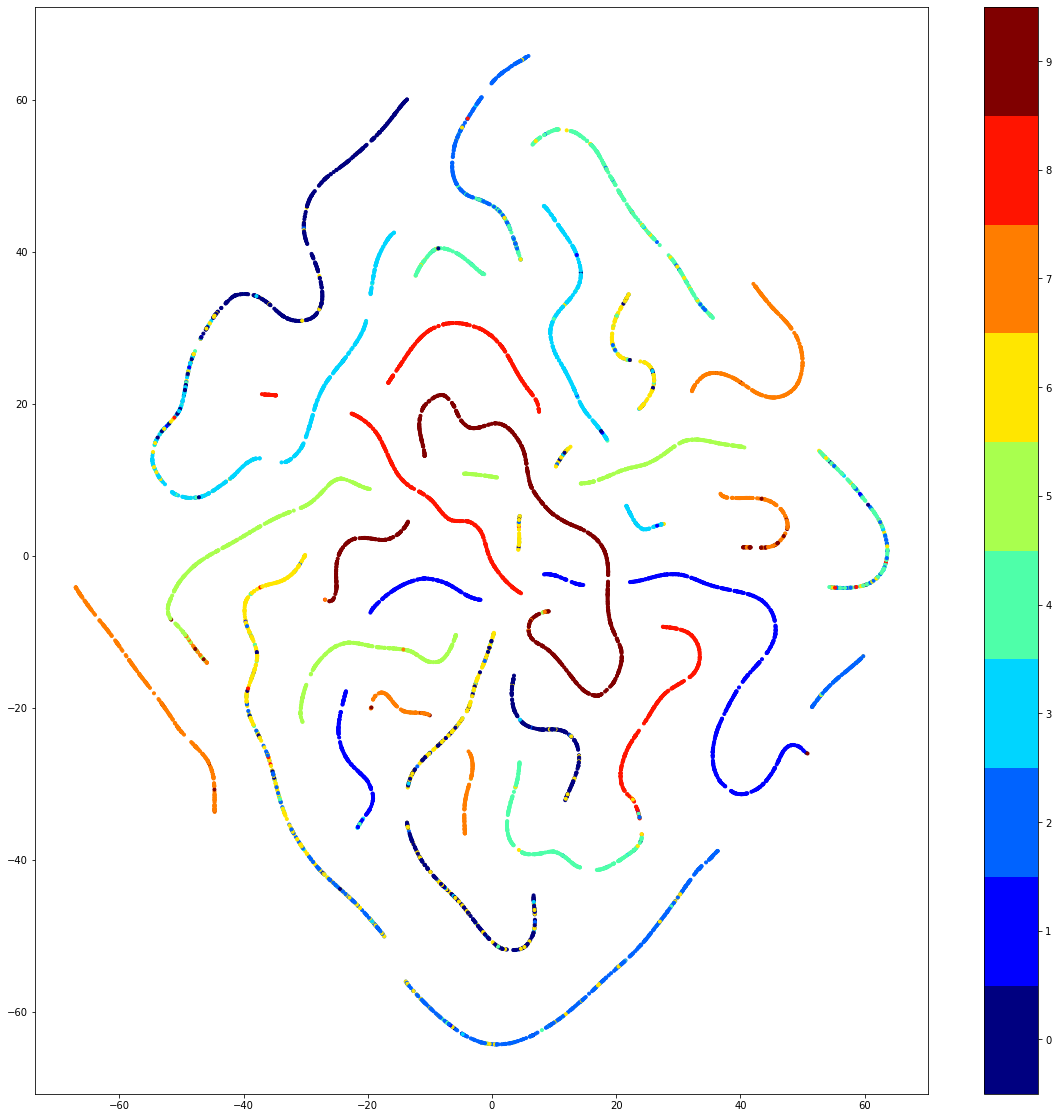

In [41]:
plt.figure(figsize=(20,20))
plt.scatter(vis_x, vis_y, c=label.cpu(), cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()